In [1]:
import netket as nk
import json
import jax
import numpy as np
import matplotlib.pyplot as plt
from time import time
import jax.numpy as jnp
from pathlib import Path
from Hamiltonians import Kitaev
from Utils import draw_kitaev_honeycomb
from Models import RestrictedBoltzmannMachine
import mpltern
from itertools import product
from Drivers import PenaltyBasedVMC
from Utils import load_variational_state, save_variational_state

In [2]:
image_path = Path('./images/8-HeisenbergChainHistogram')
res_path = Path('./Simulations/8-HeisenbergChainHistogram')
jax.devices()

[CudaDevice(id=0)]

In [3]:
n_samples = 2 * 1024
alpha = 3
Sz = 0
lr = 0.05
ds = 0.1
n_iter = 800
n_chains = 32
penalty = 1 #4
stddev = 0.05

In [4]:
extent = [5, 5]

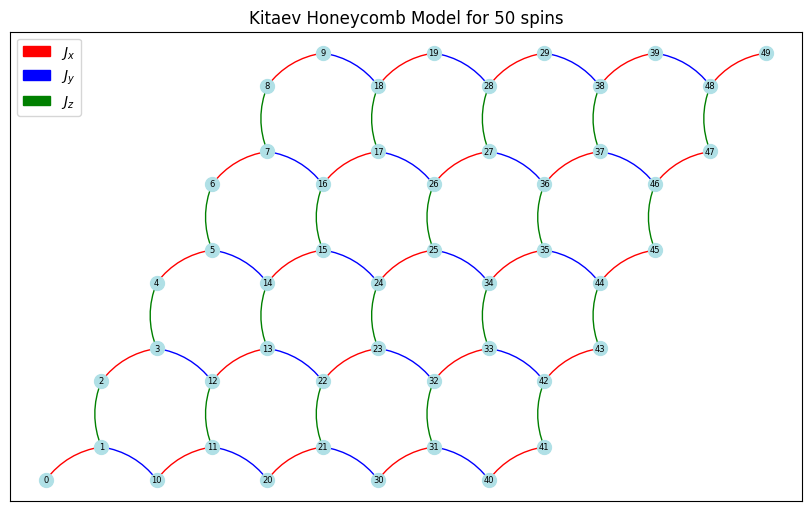

In [8]:
graph = nk.graph.KitaevHoneycomb(extent=extent, pbc=True)
hilbert = nk.hilbert.Spin(s=1/2, N=graph.n_nodes, total_sz=Sz)
figure, axes = plt.subplots(1, 1, figsize=(8, 5), layout='constrained')
draw_kitaev_honeycomb(nk.graph.KitaevHoneycomb(extent=extent, pbc=False),
                      ax=axes, node_size=100, font_size=6)
axes.set(title=f'Kitaev Honeycomb Model for {graph.n_nodes} spins');

In [6]:
dJ, J0 = 0.5, 0.2 # 121
J_scale = np.arange(J0, 1, dJ)
J_product = np.array(list(product(J_scale, repeat=3)))
J_product /= np.sum(J_product, axis=1, keepdims=True)
J_product = np.unique(J_product, axis=0)
J_product = np.delete(J_product, 3, axis=0)
print(J_product)
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(1, 1, 1, projection='ternary')
# # levels = np.linspace(min(energy_gaps), max(energy_gaps), 1000)
# pc = ax.scatter(J_product[:, 0], J_product[:, 1], J_product[:, 2], s=300, cmap='bwr', zorder=3)

[[0.125      0.4375     0.4375    ]
 [0.18181818 0.18181818 0.63636364]
 [0.18181818 0.63636364 0.18181818]
 [0.33333333 0.33333333 0.33333333]
 [0.4375     0.125      0.4375    ]
 [0.4375     0.4375     0.125     ]
 [0.63636364 0.18181818 0.18181818]]


In [7]:
J = tuple(J_product[3])
hamiltonian = Kitaev(hilbert=hilbert, graph=graph, J=J)
hamiltonian

Kitaev(Jx=0.33333333333333337, Jy=0.33333333333333337, Jz=0.33333333333333337, dim=50, #acting on=75 locations)

In [8]:
rbm = RestrictedBoltzmannMachine(alpha=alpha, stddev=stddev)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
optimizer = nk.optimizer.Sgd(learning_rate=lr)
sr = nk.optimizer.SR(diag_shift=ds)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=n_samples)
gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)

In [9]:
optimization_path = res_path / f'KitaevPhaseN{graph.n_nodes}State0'
start = time()
gs.run(n_iter=n_iter, out=str(optimization_path))
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/800 [00:00<?, ?it/s]

Time: 669.674 seconds


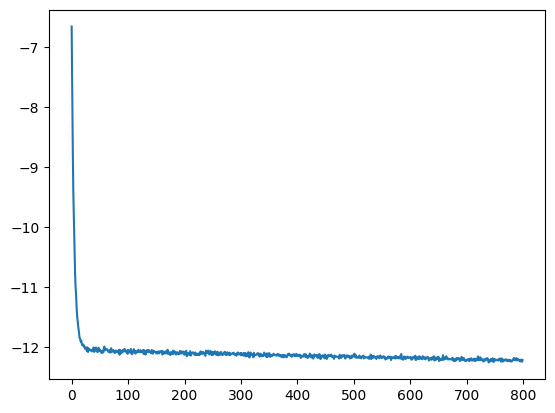

In [10]:
with open(f'{optimization_path}.log', 'r') as logs:
     data = json.load(logs)
     iters = data['Energy']['iters']
     energies = data['Energy']['Mean']
plt.plot(iters, energies)

In [11]:
save_variational_state(vstate, res_path / f'KitaevPhaseN{graph.n_nodes}Eigenstate0.json')

In [12]:
rbm = RestrictedBoltzmannMachine(alpha=alpha, stddev=stddev)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
optimizer = nk.optimizer.Sgd(learning_rate=lr)
sr = nk.optimizer.SR(diag_shift=ds)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=n_samples)
previous_state = [load_variational_state(res_path / f'KitaevPhaseN{graph.n_nodes}Eigenstate0.json',
                                         sampler, rbm, n_samples=n_samples)]

In [13]:
excited_gs = PenaltyBasedVMC(hamiltonian=hamiltonian,
                             optimizer=optimizer,
                             preconditioner=sr,
                             variational_state=vstate,
                             state_list=previous_state,
                             penalty_list=[penalty])

In [14]:
optimization_excited_path = res_path / f'KitaevPhaseN{graph.n_nodes}State1'
start = time()
excited_gs.run(n_iter=n_iter, out=str(optimization_excited_path))
print(f'Time: {time()-start:.3f} seconds')

  0%|          | 0/800 [00:00<?, ?it/s]

Time: 1212.972 seconds


[(-13.0, -11.0)]

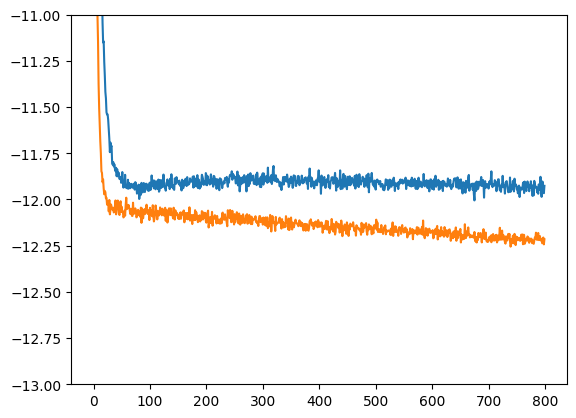

In [17]:
with open(f'{optimization_excited_path}.log', 'r') as logs:
     data_ex = json.load(logs)
     iters_ex = data_ex['Energy']['iters']
     energies_ex = data_ex['Energy']['Mean']
figure, axes = plt.subplots(1, 1)
axes.plot(iters_ex, energies_ex)
axes.plot(iters, energies)
axes.set(ylim=[-13, -11])

In [16]:
optimization_excited_path

PosixPath('Simulations/8-HeisenbergChainHistogram/KitaevPhaseN50State1')

In [26]:
n_samples = 4 * 1024
alpha = 3
Sz = 0
lr = 0.1
ds = 0.1
n_iter_gs = 600
n_iter_ex = 800
penalty = 6 #4
stddev = 0.05
extent = [5, 5]

In [ ]:
diagram_dict = {}
for index, J_params in enumerate(J_product):
    J_dict_gs, J_dict_ex = {}, {}
    print(f'CURRENT PARAM: {J_params}')
    hamiltonian = Kitaev(hilbert=hilbert, graph=graph, J=J_params.tolist())
    print(hamiltonian)
    rbm = RestrictedBoltzmannMachine(alpha=alpha, stddev=stddev, param_dtype=jnp.complex64)
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
    optimizer = nk.optimizer.Sgd(learning_rate=lr)
    sr = nk.optimizer.SR(diag_shift=ds, holomorphic=True)
    vstate = nk.vqs.MCState(sampler, rbm, n_samples=n_samples)
    gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, preconditioner=sr, variational_state=vstate)
    
    optimization_path = res_path / f'KitaevPhaseJ{J_params.tolist()}N{graph.n_nodes}State0'
    start = time()
    print(f'Ground state running')
    gs.run(n_iter=n_iter_gs, out=str(optimization_path))
    print(f'Time: {time()-start:.3f} seconds')
    J_dict_gs['E'] = gs.energy.mean.real
    
    with open(f'{optimization_path}.log', 'r') as logs:
        data = json.load(logs)
        iters = data['Energy']['iters']
        energies = data['Energy']['Mean']['real']
    J_dict_gs['iters'] = iters
    J_dict_gs['Energy'] = energies
    
    save_variational_state(vstate, res_path / f'KitaevPhaseJ{J_params.tolist()}N{graph.n_nodes}Eigenstate0.json')
    
    rbm = RestrictedBoltzmannMachine(alpha=alpha, stddev=stddev, param_dtype=jnp.complex64)
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
    optimizer = nk.optimizer.Sgd(learning_rate=lr)
    sr = nk.optimizer.SR(diag_shift=ds, holomorphic=True)
    vstate = nk.vqs.MCState(sampler, rbm, n_samples=n_samples)
    previous_state = [load_variational_state(res_path / f'KitaevPhaseJ{J_params.tolist()}N{graph.n_nodes}Eigenstate0.json', sampler, rbm, n_samples=n_samples)]
    
    excited_gs = PenaltyBasedVMC(hamiltonian=hamiltonian,
                             optimizer=optimizer,
                             preconditioner=sr,
                             variational_state=vstate,
                             state_list=previous_state,
                             penalty_list=[penalty])
    
    optimization_excited_path = res_path / f'KitaevPhaseJ{J_params.tolist()}N{graph.n_nodes}State1'
    start = time()
    print('Excited state running')
    excited_gs.run(n_iter=n_iter_ex, out=str(optimization_excited_path))
    print(f'Time: {time()-start:.3f} seconds')
    J_dict_ex['E'] = excited_gs.energy.mean.real
    
    with open(f'{optimization_excited_path}.log', 'r') as logs:
        data_ex = json.load(logs)
        iters_ex = data_ex['Energy']['iters']
        energies_ex = data_ex['Energy']['Mean']['real']
    J_dict_ex['iters'] = iters_ex
    J_dict_ex['Energy'] = energies_ex
    diagram_dict[tuple(J_params.tolist())] = (J_dict_gs, J_dict_ex)

CURRENT PARAM: [0.125  0.4375 0.4375]
Kitaev(Jx=0.125, Jy=0.438, Jz=0.438, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 2055.449 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 4990.555 seconds
CURRENT PARAM: [0.18181818 0.18181818 0.63636364]
Kitaev(Jx=0.182, Jy=0.182, Jz=0.636, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 2095.783 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 5038.918 seconds
CURRENT PARAM: [0.18181818 0.63636364 0.18181818]
Kitaev(Jx=0.182, Jy=0.636, Jz=0.182, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 1934.236 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 4877.165 seconds
CURRENT PARAM: [0.33333333 0.33333333 0.33333333]
Kitaev(Jx=0.333, Jy=0.333, Jz=0.333, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 1966.460 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 4817.160 seconds
CURRENT PARAM: [0.4375 0.125  0.4375]
Kitaev(Jx=0.438, Jy=0.125, Jz=0.438, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 1934.850 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 5082.666 seconds
CURRENT PARAM: [0.4375 0.4375 0.125 ]
Kitaev(Jx=0.438, Jy=0.438, Jz=0.125, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 1961.047 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

Time: 4877.044 seconds
CURRENT PARAM: [0.63636364 0.18181818 0.18181818]
Kitaev(Jx=0.636, Jy=0.182, Jz=0.182, dim=50, #acting on=75 locations)
Ground state running


  0%|          | 0/600 [00:00<?, ?it/s]

Time: 1924.927 seconds
Excited state running


  0%|          | 0/800 [00:00<?, ?it/s]

In [23]:
deltaEs = []
for key in diagram_dict.keys():
    ex, gss = diagram_dict[key]
    dE = ex['E'] - gss['E']
    deltaEs.append(dE)

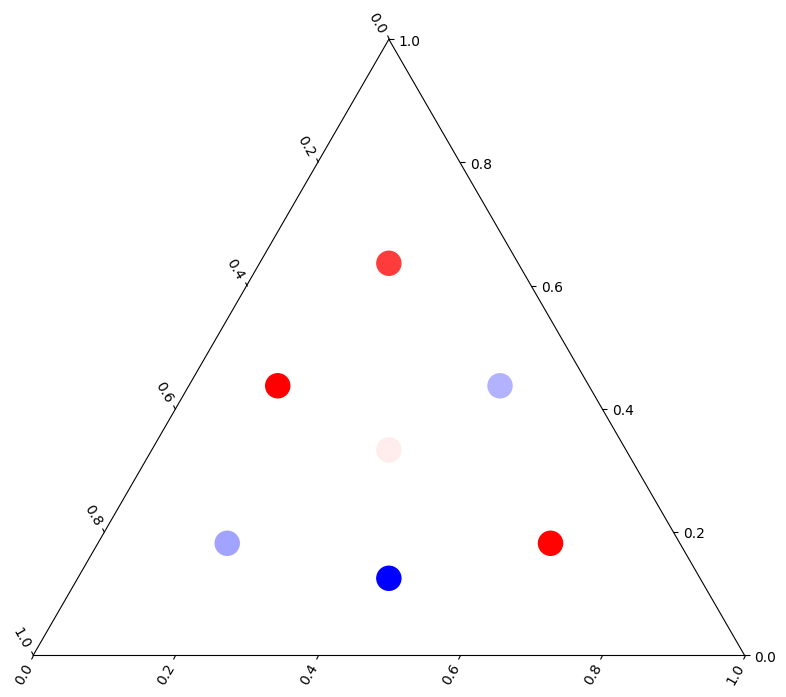

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection='ternary')
# levels = np.linspace(min(energy_gaps), max(energy_gaps), 1000)
pc = ax.scatter(J_product[:, 0], J_product[:, 1], J_product[:, 2], c=deltaEs, s=300, cmap='bwr', zorder=3)